In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from sklearn.datasets import fetch_openml
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.neural_network import MLPClassifier
    import seaborn as sns
except ImportError as e:
    import subprocess
    import sys

    print(f"Missing package: {str(e).split()[-1]}")
    print("Installing required packages...")

# **Part 1:**
# 
*Follow the steps in the first link below to compute the forward and backward passes of the neural network. Use the 2nd link to assist you with this task (look at the last cell). Use the same weights and inputs and print out the new weights connected to the hidden and output layers. (You should print the exact weight values computed in the first link)*

[https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)

[https://github.com/snsie/ai-webdev/blob/main/lessons/lesson-02/lesson-02.solutions.ipynb](https://github.com/snsie/ai-webdev/blob/main/lessons/lesson-02/lesson-02.solutions.ipynb)


In [3]:
# create inputs array from example webpage
inputs=[0.05,0.1]

# create outputs array from example webpage
outputs=[0.01,0.99]

# create learning rate from example webpage
lr=0.5

In [4]:
# combine the forward pass functions to create a reusable class
class NnFp():
  """
  computes single forward step of neural network
  """
  def __init__(self,inputs,outputs):
    self.inputs = inputs
    self.outputs = outputs
    self.weightsToHl=np.array([[.15,0.25],[0.2,0.3],[0.35,0.35]])
    self.weightsToOl=np.array([[.4,0.5],[0.45,0.55],[0.6,0.6]])

  def sigmoid(self,x,derivative=False):
    output = 1/(1+np.exp(-x))
    if derivative:
      return output*(1-output)
    return output

  def getHlNet(self):
    inputsWithBias = np.array([*self.inputs,1])
    #multiply 1x3 input array with 3x2 weights array
    return inputsWithBias @ self.weightsToHl

  def getHlOutputs(self):
    hlNet = self.getHlNet()
    return self.sigmoid(x=hlNet)

  def getOlNet(self):
    hlOutputs=self.getHlOutputs()
    hlOutputsWithBias=np.array([*hlOutputs,1])
    return hlOutputsWithBias @ self.weightsToOl

  def getOlOutputs(self):
    olNet=self.getOlNet()
    return self.sigmoid(olNet)
# create a new class that inherits the forward pass class and combines 
# the backward pass functions to create a reusable object that computes both 
# the forward and backward passes of the network
class NeuralNet(NnFp):
    """
    updates weights via backpropagation
    """
    def __init__(self,inputs,outputs, lr):
        super().__init__(inputs,outputs)
        self.lr=lr
    
    # get the change in total error with respect to each ol output
    def get_dE_dOlOut(self):
      predOutputs=self.getOlOutputs()
      targets = self.outputs
      return predOutputs-targets

    def get_dOlOut_dOlNet(self):
      olNet=self.getOlNet()
      return self.sigmoid(olNet,derivative=True)

    def get_dOlNet_dWOl(self):
      hlOutputs=self.getHlOutputs()
      hlOutputsWithBias=np.array([*hlOutputs,1])
      return hlOutputsWithBias.reshape(len(hlOutputsWithBias),1)
      
    def get_dE_dOlNet(self):
      dE_dOlOut=self.get_dE_dOlOut()
      dOlOut_dOlNet=self.get_dOlOut_dOlNet()
      dE_dOlNet=dE_dOlOut*dOlOut_dOlNet
      return dE_dOlNet

    def getPartialWeightsToOl(self):
      dE_dOlNet=self.get_dE_dOlNet()
      dE_dOlNet=dE_dOlNet.reshape(1,len(dE_dOlNet))
      dOlNet_dWOl=self.get_dOlNet_dWOl()
      return dOlNet_dWOl@dE_dOlNet

    def getNextWeightsToOl(self):
      partialWeightsToOl=self.getPartialWeightsToOl()
      nextWeightsToOl=self.weightsToOl-self.lr*partialWeightsToOl
      return nextWeightsToOl

    ########## updating weights to hidden layer below

    def get_dE_dHlOut(self):
      dE_dOlNet=self.get_dE_dOlNet()
      dE_dOlNet=dE_dOlNet.reshape(np.size(dE_dOlNet),1)
      weightsToOlWithoutBias=np.delete(self.weightsToOl,2,0)
      dOlNet_dHlOut=weightsToOlWithoutBias
      return dOlNet_dHlOut@dE_dOlNet

    def get_dHlOut_dHlNet(self):
      hlNet=self.getHlNet() 
      return self.sigmoid(hlNet,derivative=True)

    def get_dHlNet_dWHl(self):
      inputsWithBias = np.array([*self.inputs,1])
      return inputsWithBias.reshape(len(inputsWithBias),1)

    def get_dE_dHlNet(self):
      dE_dHlOut=self.get_dE_dHlOut().flatten()
      dHlOut_dHlNet=self.get_dHlOut_dHlNet()
      return dE_dHlOut*dHlOut_dHlNet

    # create a function to calculate the change in total error with 
    # respect to each weight connected to the hidden nodes
    def getPartialWeightsToHl(self):
      dE_dHlNet=self.get_dE_dHlNet()
      dE_dHlNet=dE_dHlNet.reshape(1,len(dE_dHlNet))
      dHlNet_dWHl=self.get_dHlNet_dWHl()
      return dHlNet_dWHl@dE_dHlNet

    def getNextWeightsToHl(self):
      partialWeightsToHl=self.getPartialWeightsToHl()
      nextWeightsToHl=self.weightsToHl-self.lr*partialWeightsToHl
      return nextWeightsToHl

    def getNextWeightsToHl(self):
      partialWeightsToHl=self.getPartialWeightsToHl()
      nextWeightsToHl=self.weightsToHl-self.lr*partialWeightsToHl
      return nextWeightsToHl

net=NeuralNet(inputs,outputs,lr)
hl_weights = net.getNextWeightsToHl()
ol_weights = net.getNextWeightsToOl()

print('Output layer weights: ')
print(ol_weights)
print('Hidden layer weights: ')
print(hl_weights)

Output layer weights: 
[[0.35891648 0.51130127]
 [0.40866619 0.56137012]
 [0.53075072 0.61904912]]
Hidden layer weights: 
[[0.14978072 0.24975114]
 [0.19956143 0.29950229]
 [0.34561432 0.34502287]]


**Conclusion**

*For output layer weights: w1 = 0.3589, w2 = 0.4087, w3 = 0.5113, w4 = 0.5614, wh1 = 0.5308, wh2 = 0.6191.*
*For hidden layer weights: w5 = 0.1498, w6 = 0.1996, w7 = 0.2498, w8 = 0.2995, wh1 = 0.3456, wh2 = 0.3450.*

*These are the same values as in the link, upon review.*

# **Part 2:**
# 
*Create a neural network using Numpy and train it on the MNIST dataset. (Cursor will assist you)*
*Evaluate the accuracy and F1 scores for each of the 10 digits. Use figures to visualize your results.*


Dataset dimensions:
Number of samples: 70000
Number of features: 784

Total dataset size: 54880000 elements

Number of classes: 10
Training set shape: (56000, 784)
Testing set shape: (14000, 784)

Scaled training set shape: (56000, 784)
Scaled testing set shape: (14000, 784)
Neural Network Accuracy: 0.9707

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1343
           1       0.99      0.98      0.99      1600
           2       0.96      0.96      0.96      1380
           3       0.97      0.97      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.98      0.97      0.97      1273
           6       0.98      0.99      0.98      1396
           7       0.96      0.97      0.97      1503
           8       0.96      0.96      0.96      1357
           9       0.96      0.96      0.96      1420

    accuracy                           0.97     14000
   

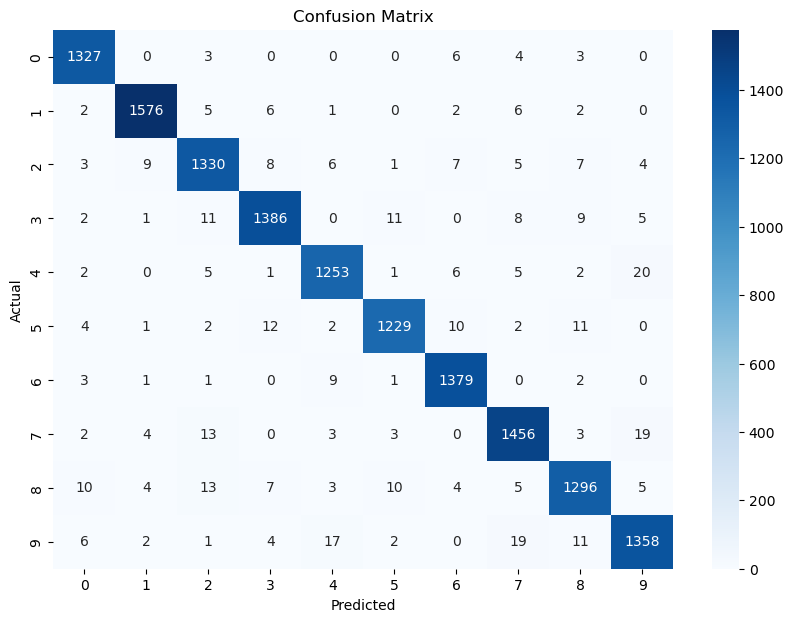

F1 Scores for each digit:
Digit 0: 0.9815
Digit 1: 0.9856
Digit 2: 0.9624
Digit 3: 0.9702
Digit 4: 0.9679
Digit 5: 0.9712
Digit 6: 0.9815
Digit 7: 0.9665
Digit 8: 0.9589
Digit 9: 0.9594


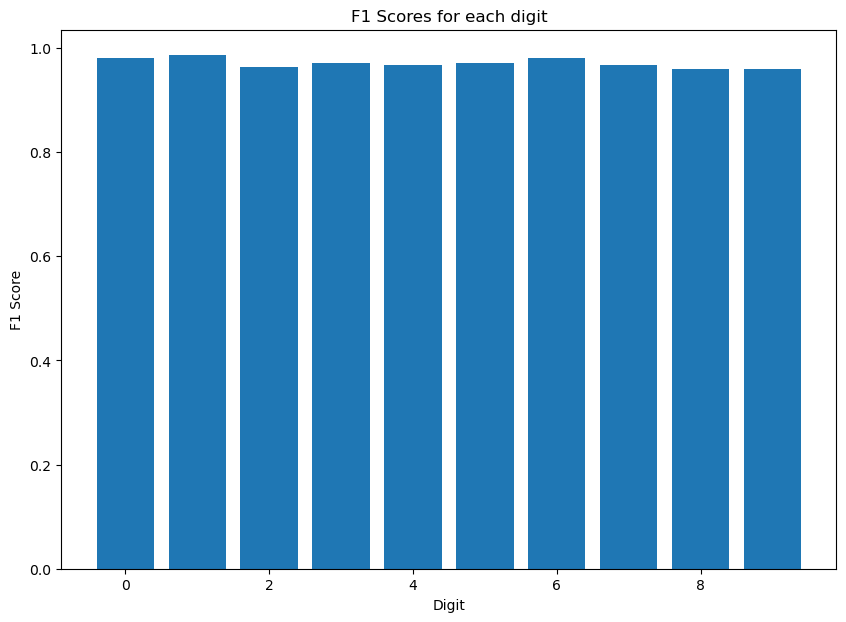

In [11]:
# Load MNIST dataset
# Make sure to run imports first
from sklearn.datasets import fetch_openml

# Load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Convert data to float32 for better memory efficiency
X = X.astype('float32')

# Print dataset dimensions
print("Dataset dimensions:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nTotal dataset size: {X.size} elements")

# Print number of unique classes
unique_classes = len(pd.Series(y).unique())
print(f"\nNumber of classes: {unique_classes}")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale pixel values to range [0,1]
X = X / 255.0

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Combined fit and transform for training data
X_test_scaled = scaler.transform(X_test)  # Only transform for test data

# Print shapes of training and test sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nScaled training set shape:", X_train_scaled.shape)
print("Scaled testing set shape:", X_test_scaled.shape)

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Create and train Neural Network model
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    random_state=42,
    max_iter=1000
)

# Train the model
nn_model.fit(X_train_scaled, y_train)

# Make predictions
nn_predictions = nn_model.predict(X_test_scaled)

# Calculate and print accuracy
nn_accuracy = accuracy_score(y_test, nn_predictions)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

print("\nNeural Network Classification Report:")
print(classification_report(y_test, nn_predictions))

nn_cm = confusion_matrix(y_test, nn_predictions)

# Plot confusion matrix
# Neural Network confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import f1_score

# Calculate F1 score for each digit
f1_scores = f1_score(y_test, nn_predictions, average=None)

# Print F1 scores for each digit
print("F1 Scores for each digit:")
for i, score in enumerate(f1_scores):
    print(f"Digit {i}: {score:.4f}")

# Plot F1 scores
plt.figure(figsize=(10, 7))
plt.bar(range(10), f1_scores)
plt.xlabel('Digit')
plt.ylabel('F1 Score')
plt.title('F1 Scores for each digit')
plt.show()



**Conclusion**

*The above confusion matrix and F1 scores show that the neural network is able to classify the digits with high accuracy, with a maximum F1 score of 0.98 for digit 4. However, there are some misclassifications, such as digit 3 being mistaken for digit 5 and vice versa. This suggests that the neural network may need further tuning or optimization to improve its performance on these digits.*